Step 1: Dataset Selection

We are using GTZAN Dataset - Music Genre Classification

Link: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [1]:
# Import necessary libraries
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Audio processing
import librosa
from tqdm import tqdm

#### 2. Load and Inspect Data

In [2]:
# ## 2. Load and Inspect Data

# Load dataset from CSV
try:
    df = pd.read_csv('Data/features_3_sec.csv')
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst 3 rows:")
    display(df.head(3))
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully!
Shape: (9990, 60)

First 3 rows:


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues


#### 3. Data Cleaning

In [3]:
# ## 3. Data Cleaning

# %%
# Check for missing values
print("Missing values before cleaning:", df.isnull().sum())

# Check for duplicates
print("Duplicate rows before cleaning:", df.duplicated().sum())

Missing values before cleaning: filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean 

In [4]:
# Checking the shape
print(f"New shape: {df.shape}")

New shape: (9990, 60)


#### 4. Exploratory Data Analysis (EDA)

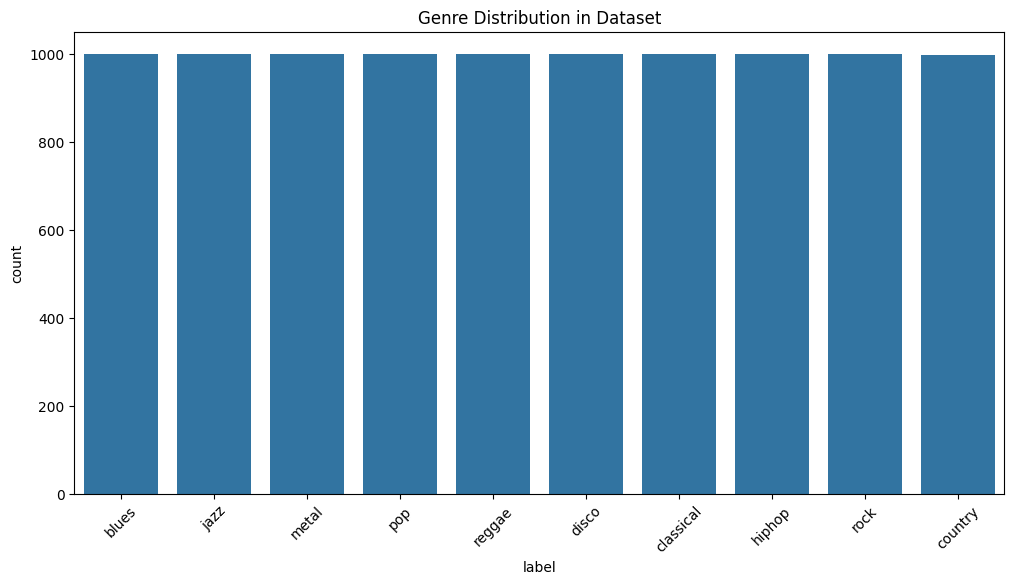

In [5]:
# ## 4. Exploratory Data Analysis (EDA)

# Class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Genre Distribution in Dataset')
plt.xticks(rotation=45)
plt.show()

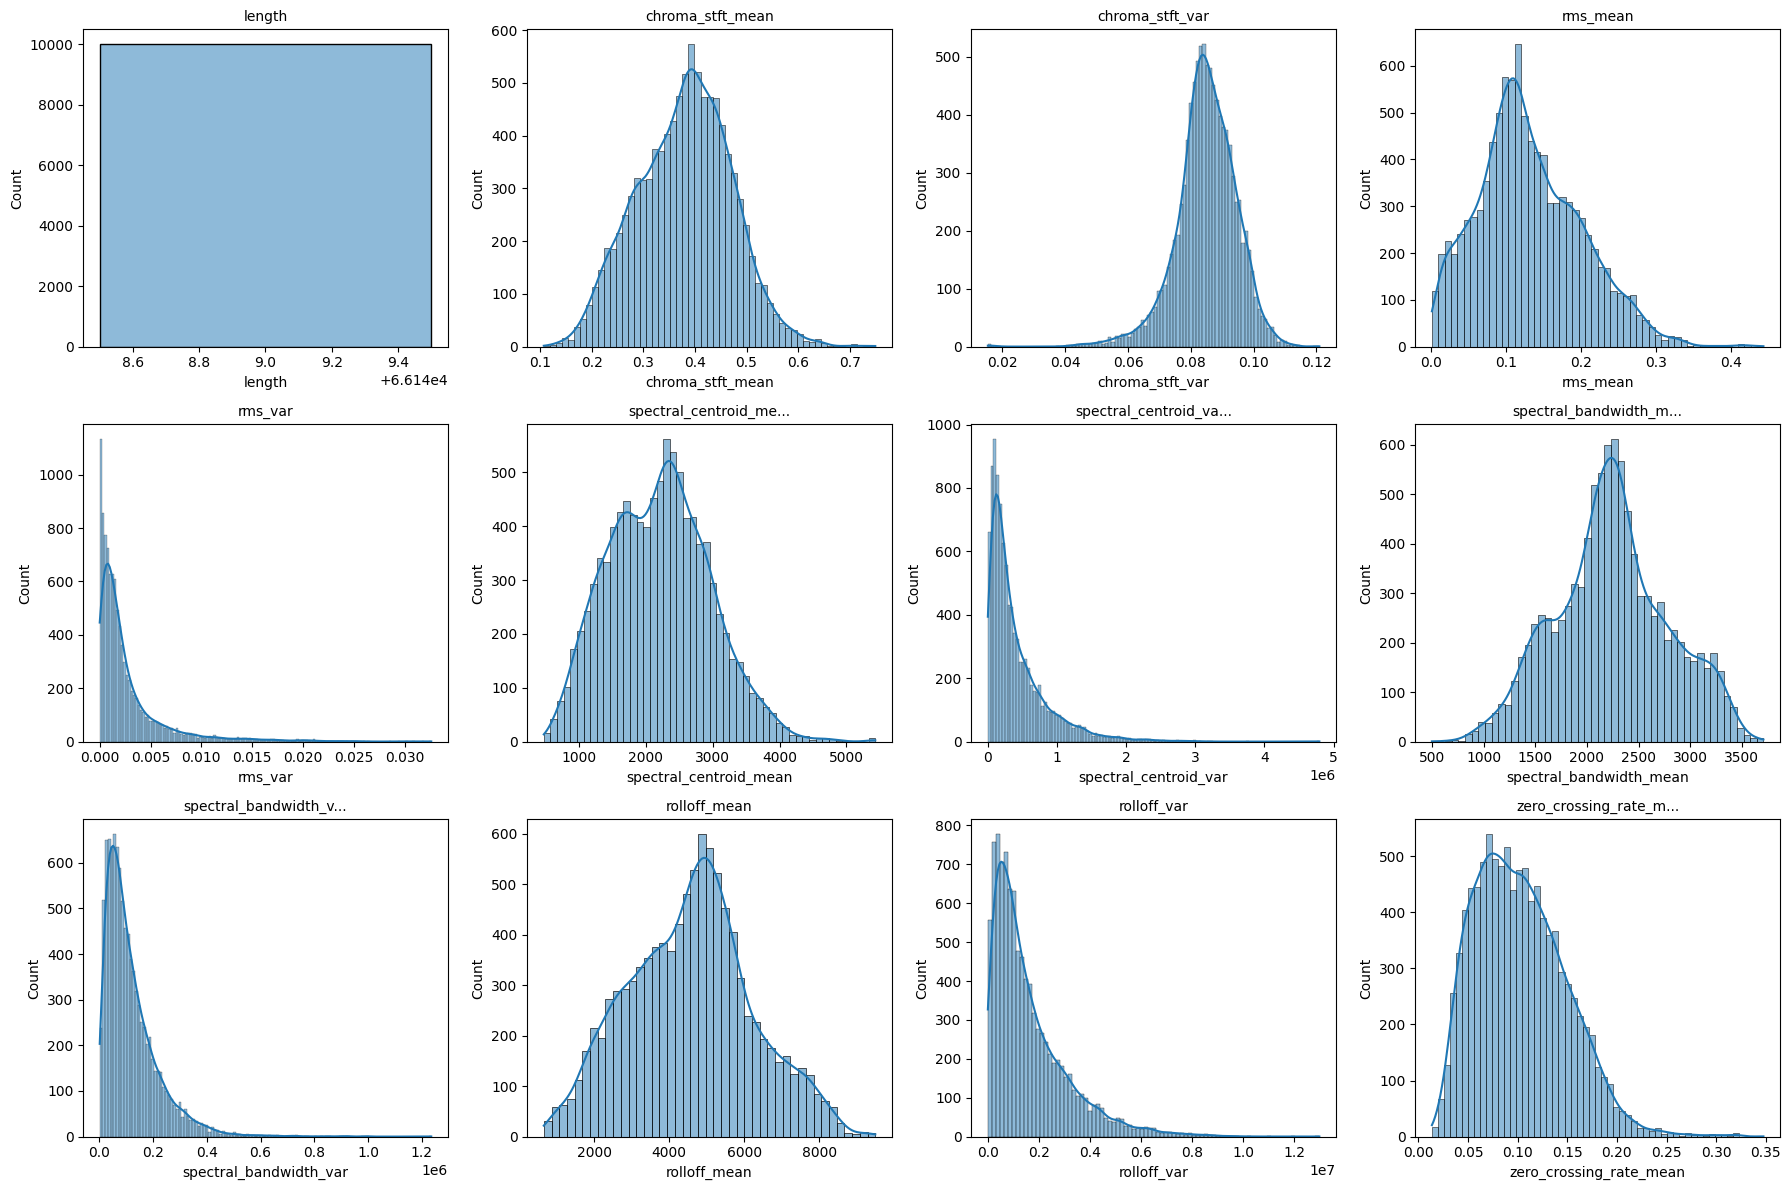

In [6]:
# Feature distributions (first 12 numeric features)
numeric_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols[:12]):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col[:20] + '...' if len(col) > 20 else col, fontsize=10)
plt.tight_layout()
plt.show()

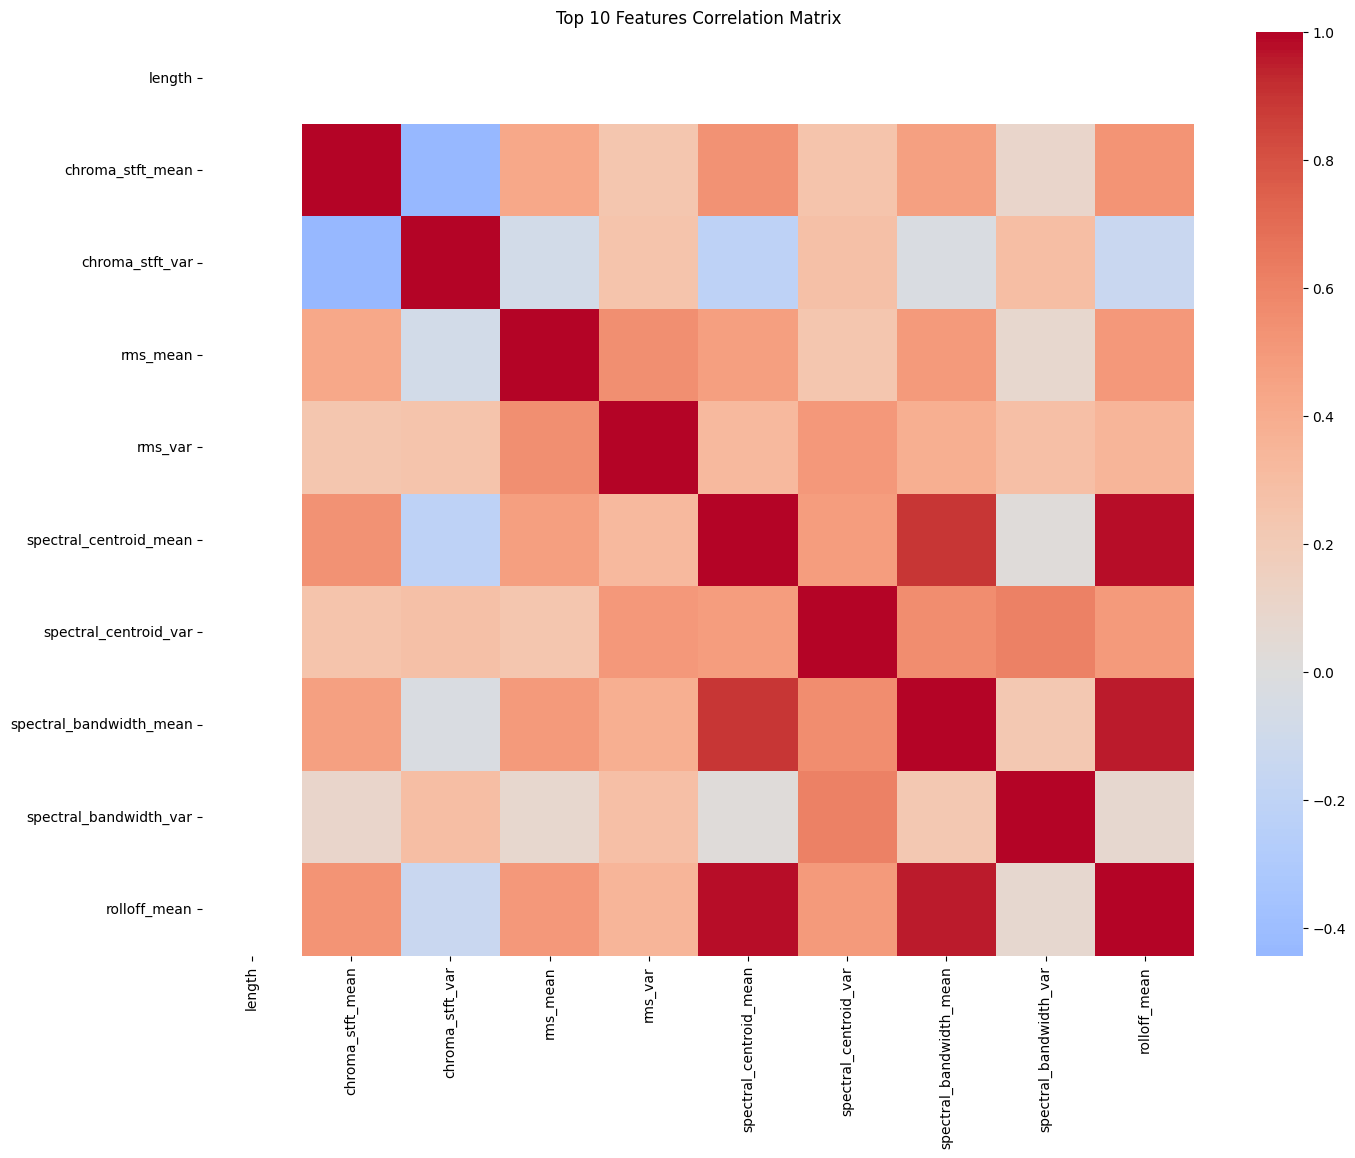

In [7]:
# Correlation matrix (top 10 features)
plt.figure(figsize=(16, 12))
corr_matrix = df[numeric_cols[:10]].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Top 10 Features Correlation Matrix')
plt.show()

In [8]:
# # Run this in a cell
# import matplotlib
# matplotlib.use('agg') # Or try 'agg' if inline didn't help
# import matplotlib.pyplot as plt
# print(f"Matplotlib backend currently set to: {matplotlib.get_backend()}")
# # Now re-run the audio visualization cell

Loaded audio for manual plot: Data//genres_original//classical//classical.00000.wav
Calculated Mel Spectrogram data.


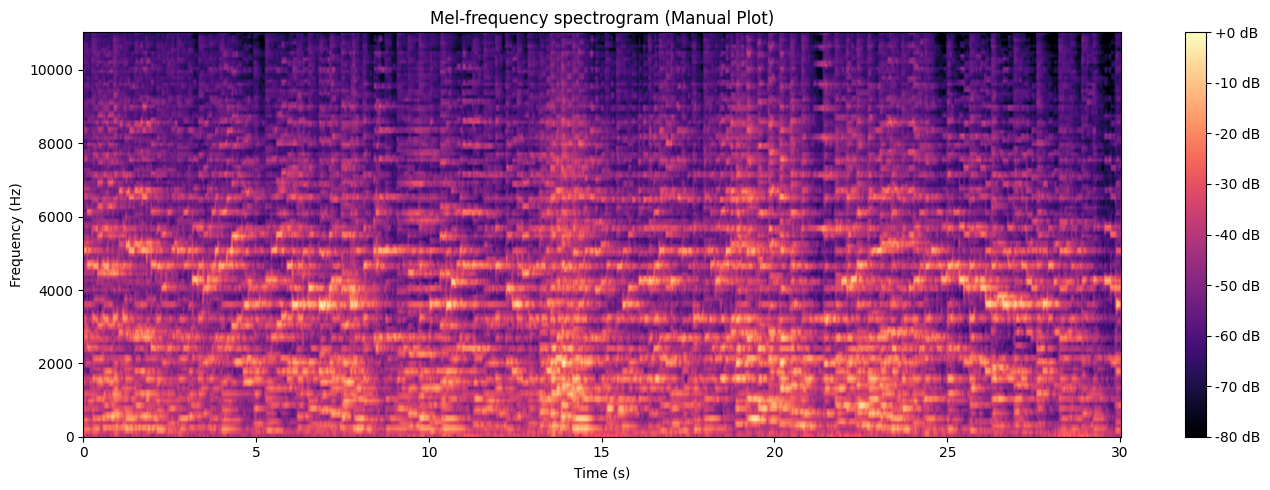

Manual spectrogram plot attempted.


In [9]:
# --- Workaround: Plot Spectrogram Manually with imshow ---
# IMPORTANT: Replace with the actual path to an example audio file
audio_file_path = 'Data//genres_original//classical//classical.00000.wav' # Using your path

try:

    # Load audio
    y_audio, sr_audio = librosa.load(audio_file_path, sr=None)
    print(f"Loaded audio for manual plot: {audio_file_path}")

    # Calculate Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y_audio, sr=sr_audio, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    print("Calculated Mel Spectrogram data.")

    # Plot using plt.imshow
    fig, ax = plt.subplots(figsize=(14, 5))
    img = ax.imshow(S_dB, aspect='auto', origin='lower', cmap='magma',
                    extent=[0, librosa.get_duration(y=y_audio, sr=sr_audio), 0, sr_audio/2]) # Basic extent setup

    # Manually set labels (approximating librosa.display)
    ax.set_title('Mel-frequency spectrogram (Manual Plot)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)') # Note: imshow uses frequency, not Mel scale directly on axis
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    print("Manual spectrogram plot attempted.")

except Exception as e:
    print(f"Error during manual spectrogram plot: {e}")

#### 5. Prepare Data for Modeling

In [10]:
# ## 5. Prepare Data for Modeling

# Separate features and target
X = df.drop(['filename', 'label'], axis=1)
y = df['label']

In [11]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("Classes:", le.classes_)

Training set shape: (7992, 58)
Test set shape: (1998, 58)
Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


#### 6. Train Traditional ML Models

In [14]:
# ## 6. Train Traditional ML Models

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

In [15]:
# Define parameter grids for tuning
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
}

Training Models:   0%|          | 0/5 [00:00<?, ?it/s]


=== Random Forest Hyperparameter Tuning ===
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score: 0.8488
Test Accuracy: 0.8714
              precision    recall  f1-score   support

       blues       0.86      0.85      0.86       200
   classical       0.92      0.96      0.94       199
     country       0.81      0.84      0.83       199
       disco       0.83      0.85      0.84       200
      hiphop       0.93      0.89      0.91       200
        jazz       0.85      0.91      0.87       200
       metal       0.87      0.95      0.91       200
         pop       0.96      0.83      0.89       200
      reggae       0.84      0.88      0.86       200
        rock       0.86      0.75      0.80       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      

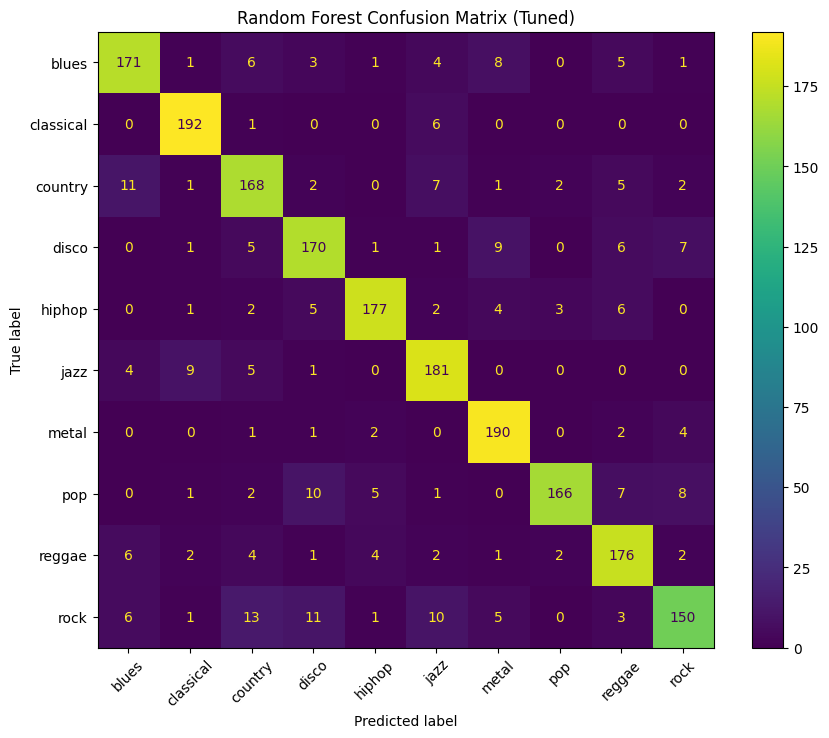

Training Models:  20%|██        | 1/5 [01:41<06:46, 101.65s/it]


=== SVM Hyperparameter Tuning ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.8958
Test Accuracy: 0.9134
              precision    recall  f1-score   support

       blues       0.90      0.94      0.92       200
   classical       0.92      0.98      0.95       199
     country       0.87      0.86      0.87       199
       disco       0.88      0.88      0.88       200
      hiphop       0.93      0.91      0.92       200
        jazz       0.92      0.94      0.93       200
       metal       0.98      0.95      0.97       200
         pop       0.94      0.86      0.90       200
      reggae       0.90      0.92      0.91       200
        rock       0.90      0.90      0.90       200

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



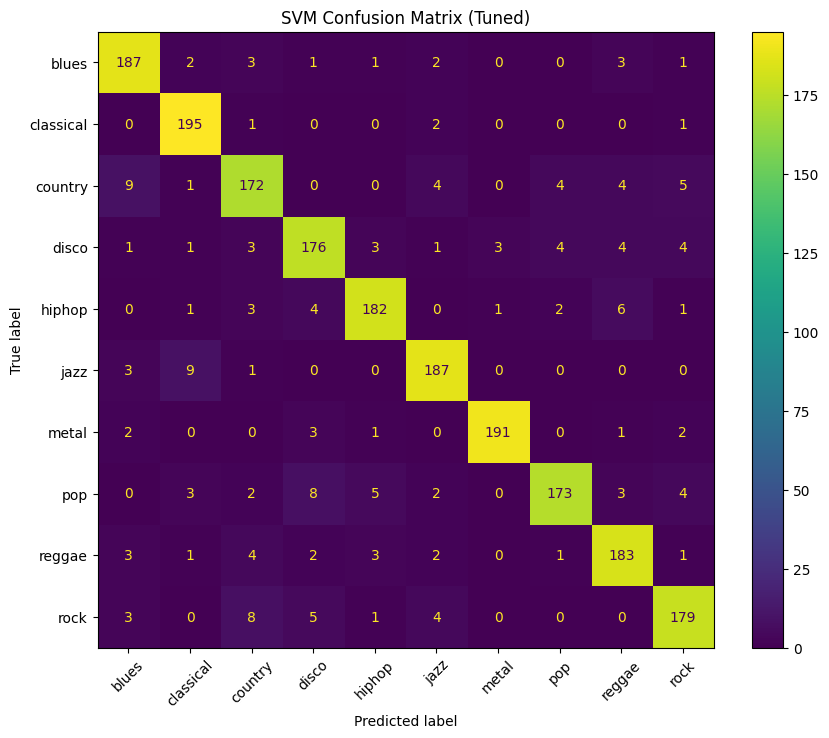

Training Models:  40%|████      | 2/5 [03:15<04:50, 96.88s/it] 


=== KNN Hyperparameter Tuning ===
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best CV score: 0.8801
Test Accuracy: 0.8919
              precision    recall  f1-score   support

       blues       0.90      0.90      0.90       200
   classical       0.90      0.93      0.91       199
     country       0.87      0.80      0.83       199
       disco       0.84      0.94      0.89       200
      hiphop       0.91      0.92      0.91       200
        jazz       0.89      0.86      0.88       200
       metal       0.97      0.97      0.97       200
         pop       0.92      0.82      0.87       200
      reggae       0.85      0.93      0.89       200
        rock       0.88      0.84      0.86       200

    accuracy                           0.89      1998
   macro avg       0.89      0.89      0.89      1998
weighted avg       0.89      0.89      0.89      1998



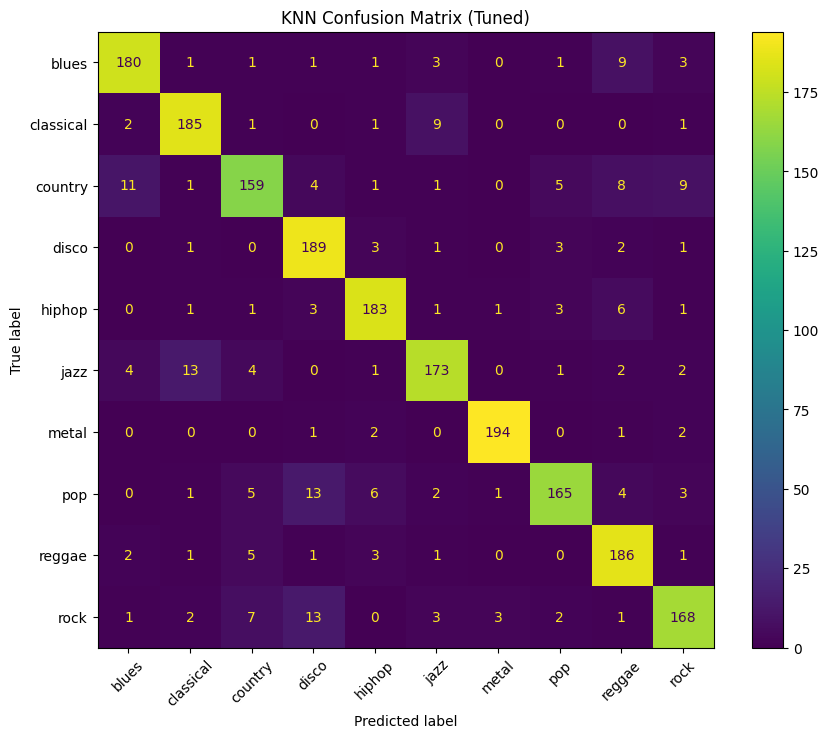

Training Models:  60%|██████    | 3/5 [03:28<01:57, 58.69s/it]


=== Logistic Regression Hyperparameter Tuning ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best CV score: 0.7117
Test Accuracy: 0.7192
              precision    recall  f1-score   support

       blues       0.67      0.70      0.68       200
   classical       0.91      0.95      0.93       199
     country       0.64      0.59      0.62       199
       disco       0.63      0.66      0.64       200
      hiphop       0.75      0.60      0.67       200
        jazz       0.79      0.84      0.81       200
       metal       0.81      0.85      0.83       200
         pop       0.79      0.77      0.78       200
      reggae       0.66      0.70      0.68       200
        rock       0.53      0.52      0.53       200

    accuracy                           0.72      1998
   macro avg       0.72      0.72      0.72      1998
weighted avg       0.72      0.72      0.72      1998



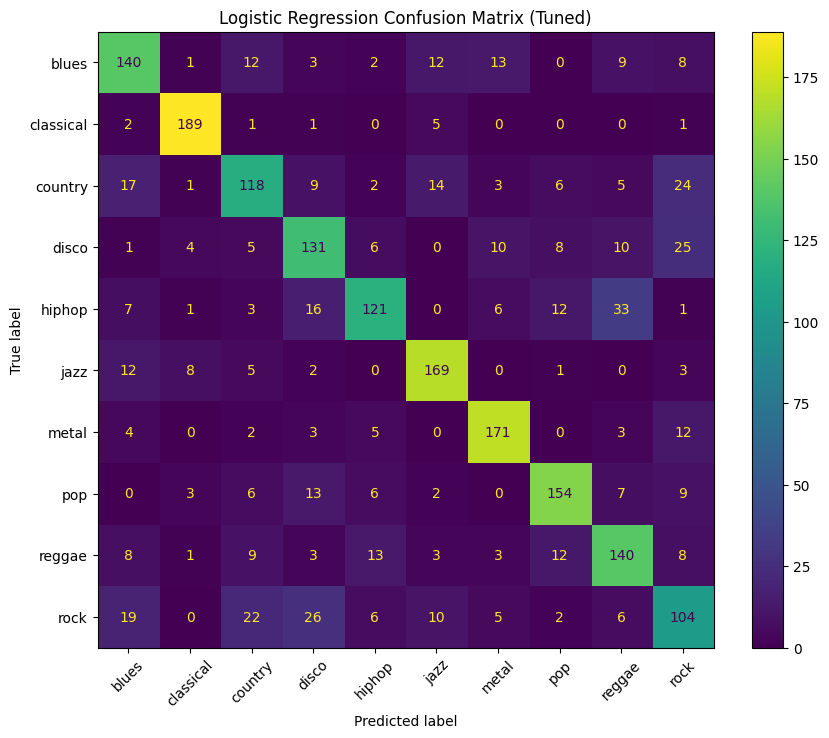

Training Models:  80%|████████  | 4/5 [05:05<01:13, 73.70s/it]


=== XGBoost Hyperparameter Tuning ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best CV score: 0.8831
Test Accuracy: 0.9019
              precision    recall  f1-score   support

       blues       0.89      0.89      0.89       200
   classical       0.94      0.97      0.95       199
     country       0.84      0.87      0.86       199
       disco       0.88      0.90      0.89       200
      hiphop       0.92      0.89      0.91       200
        jazz       0.90      0.92      0.91       200
       metal       0.95      0.96      0.95       200
         pop       0.94      0.84      0.89       200
      reggae       0.87      0.91      0.89       200
        rock       0.89      0.86      0.88       200

    accuracy                           0.90      1998
   macro avg       0.90      0.90      0.90      1998
weighted avg       0.90      0.90      0.90      1998



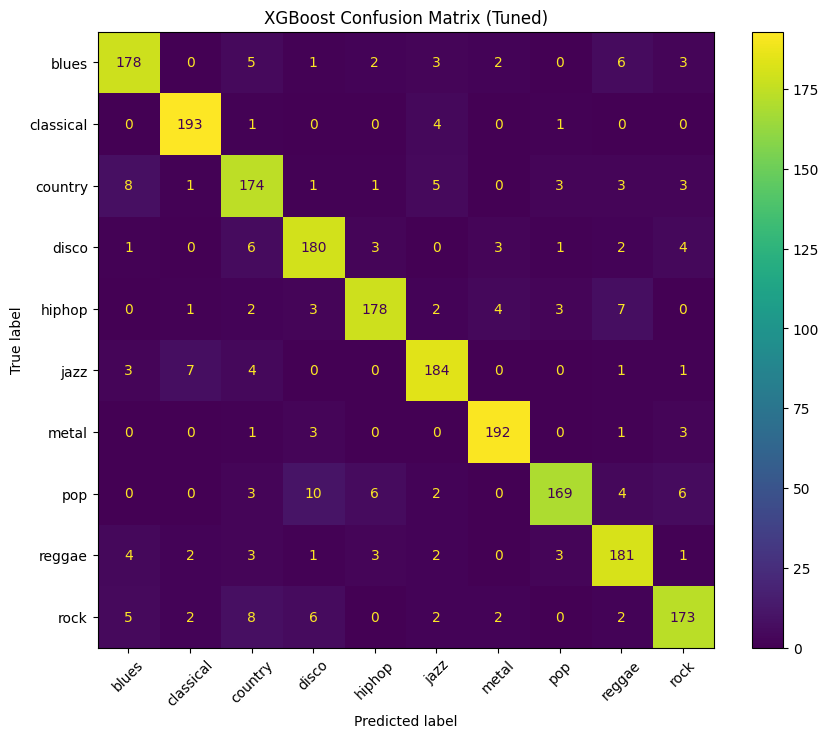

Training Models: 100%|██████████| 5/5 [06:53<00:00, 82.66s/it]


In [16]:
# Train and evaluate each model with tuning
tuned_models = {}
for name, model in tqdm(models.items(), desc="Training Models"):
    print(f"\n=== {name} Hyperparameter Tuning ===")
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    tuned_models[name] = best_model
    
    # Evaluate
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, xticks_rotation=45)
    plt.title(f'{name} Confusion Matrix (Tuned)')
    plt.show()

#### 6. Neural Network with ModelCheckpoint

In [17]:
# ## 6. Neural Network with ModelCheckpoint

# Build neural network model
nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

nn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)               

In [18]:
# Set up callbacks
checkpoint_path = "saved_models/nn_best_weights.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [19]:
# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


63/63 [==============================] - ETA: 0s - loss: 1.4453 - accuracy: 0.4800
Epoch 1: val_accuracy improved from -inf to 0.66216, saving model to saved_models\nn_best_weights.h5
63/63 [==============================] - 3s 14ms/step - loss: 1.4453 - accuracy: 0.4800 - val_loss: 0.9714 - val_accuracy: 0.6622
Epoch 2/50
58/63 [==========================>...] - ETA: 0s - loss: 0.9901 - accuracy: 0.6494
Epoch 2: val_accuracy improved from 0.66216 to 0.72823, saving model to saved_models\nn_best_weights.h5
63/63 [==============================] - 1s 9ms/step - loss: 0.9814 - accuracy: 0.6529 - val_loss: 0.7946 - val_accuracy: 0.7282
Epoch 3/50
61/63 [============================>.] - ETA: 0s - loss: 0.8143 - accuracy: 0.7141
Epoch 3: val_accuracy improved from 0.72823 to 0.76777, saving model to saved_models\nn_best_weights.h5
63/63 [==============================] - 1s 9ms/step - loss: 0.8142 - accuracy: 0.7136 - val_loss: 0.6769 - val_accuracy: 0.7678
Epoch 4/50
60/63 [=

In [20]:
# Load best weights (though EarlyStopping with restore_best_weights=True already does this)
nn_model.load_weights(checkpoint_path)


In [21]:
# Evaluate the NN Model
nn_loss, nn_acc = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nNeural Network Test Accuracy: {nn_acc:.4f}")


Neural Network Test Accuracy: 0.9124


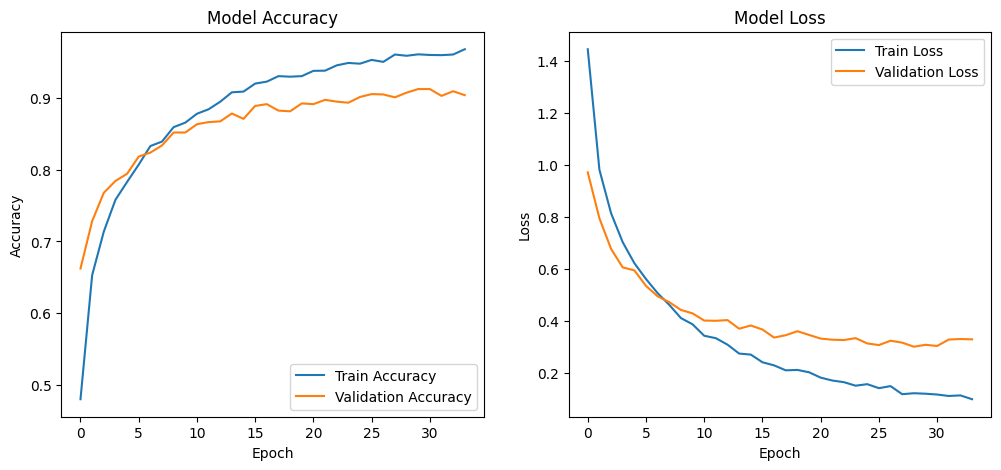

In [22]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Evaluation

In [23]:
# ## Neural Network Evaluation Metrics

# Make predictions on test set
y_pred_prob = nn_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

63/63 [==============================] - 0s 1ms/step


In [24]:
# ### 1. Classification Report

# Generate classification report
print("Neural Network Classification Report:")
print("====================================")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Neural Network Classification Report:
              precision    recall  f1-score   support

       blues       0.93      0.93      0.93       200
   classical       0.91      0.97      0.94       199
     country       0.88      0.90      0.89       199
       disco       0.90      0.88      0.89       200
      hiphop       0.90      0.92      0.91       200
        jazz       0.93      0.93      0.93       200
       metal       0.95      0.94      0.94       200
         pop       0.94      0.83      0.88       200
      reggae       0.91      0.93      0.92       200
        rock       0.88      0.91      0.89       200

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



<Figure size 1200x1000 with 0 Axes>

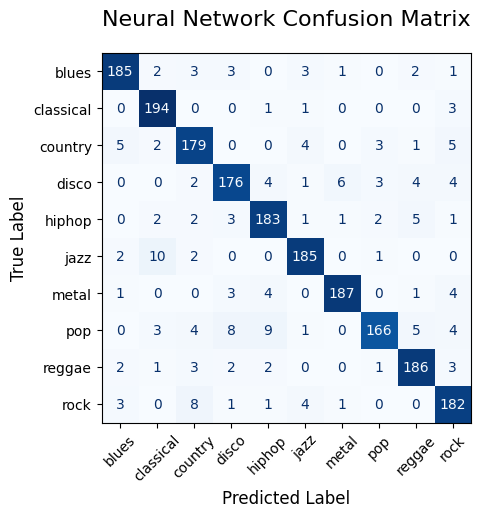

In [25]:
# ### 2. Confusion Matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)
disp.plot(
    cmap='Blues',
    xticks_rotation=45,
    values_format='d',
    colorbar=False
)
plt.title('Neural Network Confusion Matrix', pad=20, fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.grid(False)
plt.show()

In [26]:
# ### 3. Top-3 Prediction Accuracy

# Calculate top-3 accuracy
top3_correct = 0
for i in range(len(y_test)):
    top3_pred = np.argsort(y_pred_prob[i])[-3:]
    if y_test[i] in top3_pred:
        top3_correct += 1

top3_acc = top3_correct / len(y_test)
print(f"\nTop-3 Accuracy: {top3_acc:.4f}")


Top-3 Accuracy: 0.9860


Example Sample Index: 0
True Genre: country
Predicted Genre (NN): country (Confidence: 100.0%)


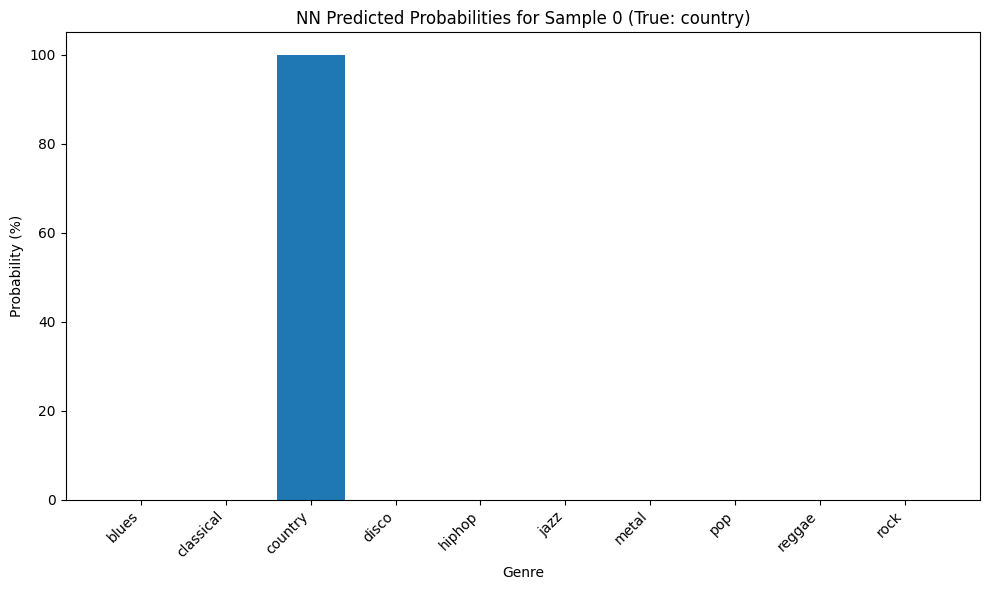

In [27]:
# --- Prediction Probability Visualization (Neural Network Example) ---
import matplotlib.pyplot as plt
import numpy as np

# Choose a sample index from the test set (e.g., the first one)
sample_index = 0
sample_features = X_test_scaled[sample_index].reshape(1, -1) # Reshape for single prediction

# Get predicted probabilities from the NN model
pred_probs = nn_model.predict(sample_features, verbose=0)[0]

# Get the predicted class index and name
predicted_class_index = np.argmax(pred_probs)
predicted_genre = le.inverse_transform([predicted_class_index])[0]
true_class_index = y_test[sample_index]
true_genre = le.inverse_transform([true_class_index])[0]


print(f"Example Sample Index: {sample_index}")
print(f"True Genre: {true_genre}")
print(f"Predicted Genre (NN): {predicted_genre} (Confidence: {pred_probs[predicted_class_index]*100:.1f}%)")


# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.bar(le.classes_, pred_probs * 100) # Multiply by 100 for percentage
plt.title(f'NN Predicted Probabilities for Sample {sample_index} (True: {true_genre})')
plt.xlabel('Genre')
plt.ylabel('Probability (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Models Evaluation

In [28]:
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import log_loss, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# --- Step 1: Get Predicted Probabilities ---

predicted_probabilities = {}
predicted_classes = {} # Also useful to store the final class predictions

print("Generating predictions and probabilities...")

# For traditional ML models
for name, model in tuned_models.items():
    try:
        # Get probabilities (shape: [n_samples, n_classes])
        probs = model.predict_proba(X_test_scaled)
        predicted_probabilities[name] = probs
        # Get class predictions
        preds = model.predict(X_test_scaled) # Or np.argmax(probs, axis=1)
        predicted_classes[name] = preds
        print(f" Probabilities generated for {name}")
    except AttributeError:
        print(f"Model {name} does not have predict_proba. Skipping probability-based metrics.")
    except Exception as e:
        print(f"Error predicting probabilities for {name}: {e}")

# For Neural Network
try:
    # Keras predict gives probabilities for softmax output layer
    nn_probs = nn_model.predict(X_test_scaled, verbose=0)
    predicted_probabilities['Neural Network'] = nn_probs
    # Get class predictions by finding the index of the max probability
    nn_preds = np.argmax(nn_probs, axis=1)
    predicted_classes['Neural Network'] = nn_preds
    print(f" Probabilities generated for Neural Network")
except Exception as e:
    print(f"Error predicting probabilities for Neural Network: {e}")

print("Finished generating probabilities.")

Generating predictions and probabilities...
 Probabilities generated for Random Forest
 Probabilities generated for SVM
 Probabilities generated for KNN
 Probabilities generated for Logistic Regression
 Probabilities generated for XGBoost
 Probabilities generated for Neural Network
Finished generating probabilities.


In [29]:
# --- Step 2: Calculate Log Loss ---

print("\n=== Log Loss Scores ===")
# Check if probabilities were generated before calculating
if predicted_probabilities:
    for name, probs in predicted_probabilities.items():
        try:
            epsilon = 1e-15
            probs_clipped = np.clip(probs, epsilon, 1 - epsilon)
            loss = log_loss(y_test, probs_clipped)
            print(f"{name}: {loss:.4f}")
        except Exception as e:
            print(f"Could not calculate log loss for {name}: {e}")
else:
    print("No probabilities available to calculate log loss.")


=== Log Loss Scores ===
Random Forest: 0.7155
SVM: 0.2723
KNN: 1.7054
Logistic Regression: 0.8342
XGBoost: 0.3013
Neural Network: 0.3058


In [30]:
# --- Step 3: Calculate AUC-ROC (OvR) ---

print("\n=== AUC-ROC Scores (One-vs-Rest) ===")

if predicted_probabilities:
    # Binarize the true labels y_test for OvR calculation
    try:
        lb = LabelBinarizer()
        lb.fit(y_test) # Fit on the original y_test labels
        y_test_binarized = lb.transform(y_test)
        n_classes = len(le.classes_)

        for name, probs in predicted_probabilities.items():
            try:
                # Check if number of probability columns matches number of classes
                if probs.shape[1] == n_classes:
                     # Ensure y_test_binarized also has the right shape if only one class predicted for some reason
                     if y_test_binarized.shape[1] == n_classes:
                         auc_ovr = roc_auc_score(y_test_binarized, probs, multi_class='ovr', average='macro')
                         print(f"{name}: {auc_ovr:.4f}")
                     else:
                         # Handle potential issue if LabelBinarizer didn't produce n_classes columns
                         # This can happen if y_test only contains a subset of all possible classes
                         # Recalculating y_test_binarized with explicit labels might be needed
                         y_test_binarized_full = lb.fit_transform(y_encoded) # Use full encoded y if y_test is incomplete
                         if y_test_binarized_full.shape[1] == n_classes:
                             # Select only the test indices
                             # Assuming y_test indices match the original split indices
                             test_indices = y_test.index # Or however you track test indices
                             y_test_binarized_for_auc = y_test_binarized_full[test_indices]
                             if y_test_binarized_for_auc.shape[0] == probs.shape[0]: # Check sample count match
                                 auc_ovr = roc_auc_score(y_test_binarized_for_auc, probs, multi_class='ovr', average='macro')
                                 print(f"{name}: {auc_ovr:.4f}")
                             else:
                                 print(f"Skipping AUC-ROC for {name}: Binarized label sample count mismatch.")
                         else:
                              print(f"Skipping AUC-ROC for {name}: Cannot binarize y_test correctly for {n_classes} classes.")

                else:
                     print(f"Skipping AUC-ROC for {name}: Probability shape mismatch ({probs.shape[1]} vs {n_classes} classes)")
            except Exception as e:
                print(f"Could not calculate AUC-ROC for {name}: {e}")

    except Exception as e:
        print(f"Error during label binarization for AUC-ROC: {e}")
else:
    print("No probabilities available to calculate AUC-ROC.")



=== AUC-ROC Scores (One-vs-Rest) ===
Random Forest: 0.9889
SVM: 0.9951
KNN: 0.9739
Logistic Regression: 0.9564
XGBoost: 0.9944
Neural Network: 0.9943


In [31]:
# --- Step 4: Recalculate Classification Report and Confusion Matrix ---
# Use the 'predicted_classes' dictionary generated in Step 1

print("\n=== Classification Reports (using stored predictions) ===")
for name, preds in predicted_classes.items():
     print(f"\n--- {name} ---")
     print(classification_report(y_test, preds, target_names=le.classes_))


=== Classification Reports (using stored predictions) ===

--- Random Forest ---
              precision    recall  f1-score   support

       blues       0.86      0.85      0.86       200
   classical       0.92      0.96      0.94       199
     country       0.81      0.84      0.83       199
       disco       0.83      0.85      0.84       200
      hiphop       0.93      0.89      0.91       200
        jazz       0.85      0.91      0.87       200
       metal       0.87      0.95      0.91       200
         pop       0.96      0.83      0.89       200
      reggae       0.84      0.88      0.86       200
        rock       0.86      0.75      0.80       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998


--- SVM ---
              precision    recall  f1-score   support

       blues       0.90      0.94      0.92       200
   classical       0.92      0.98    


=== Confusion Matrices (using stored predictions) ===


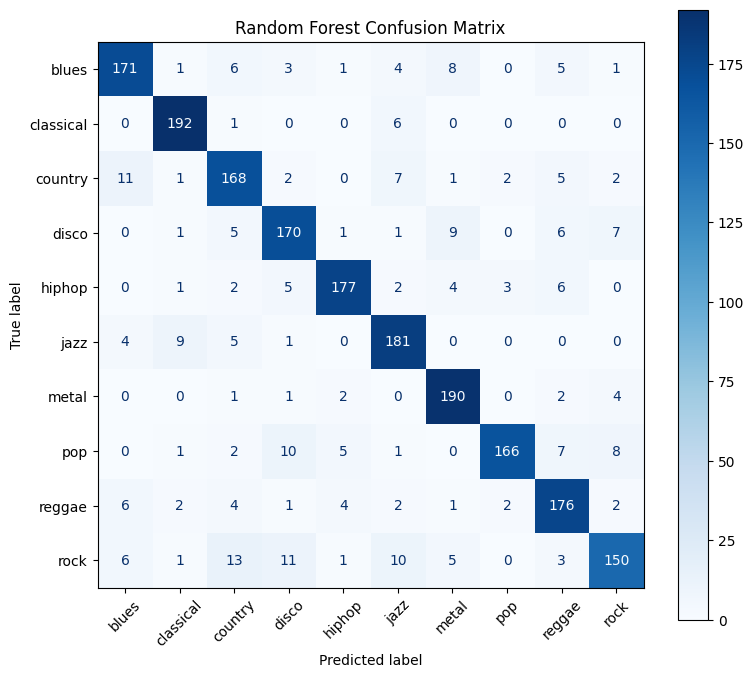

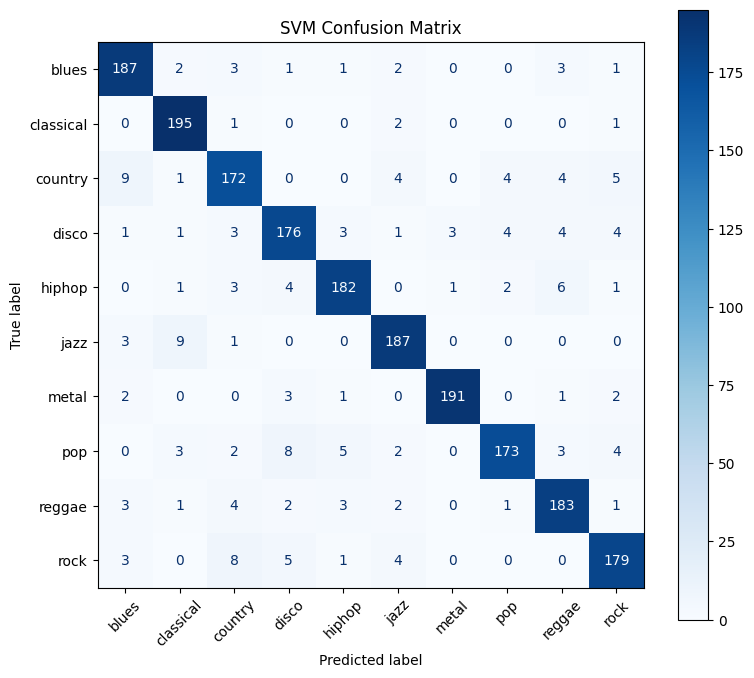

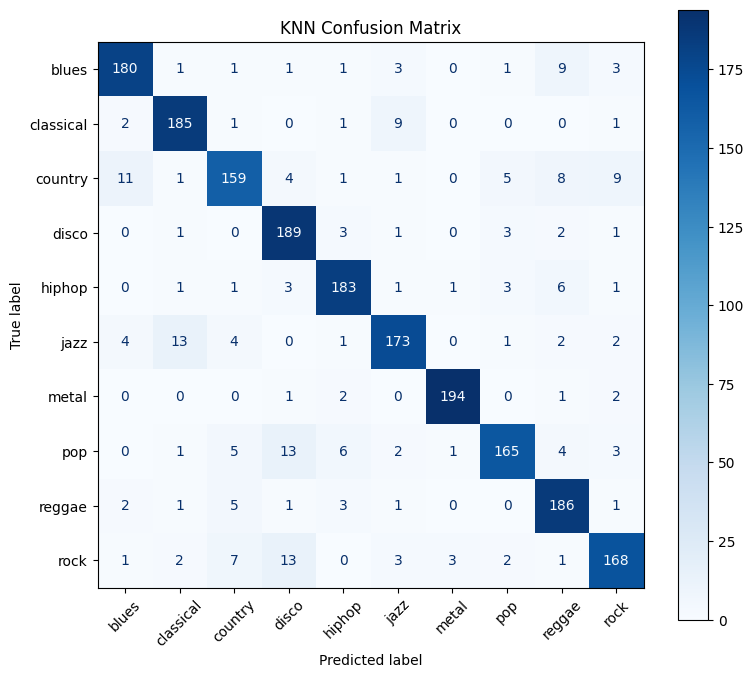

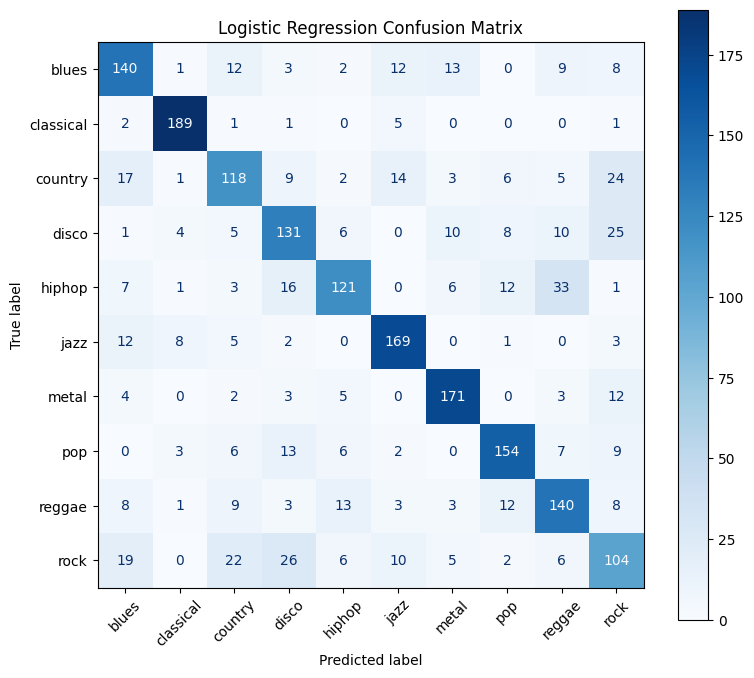

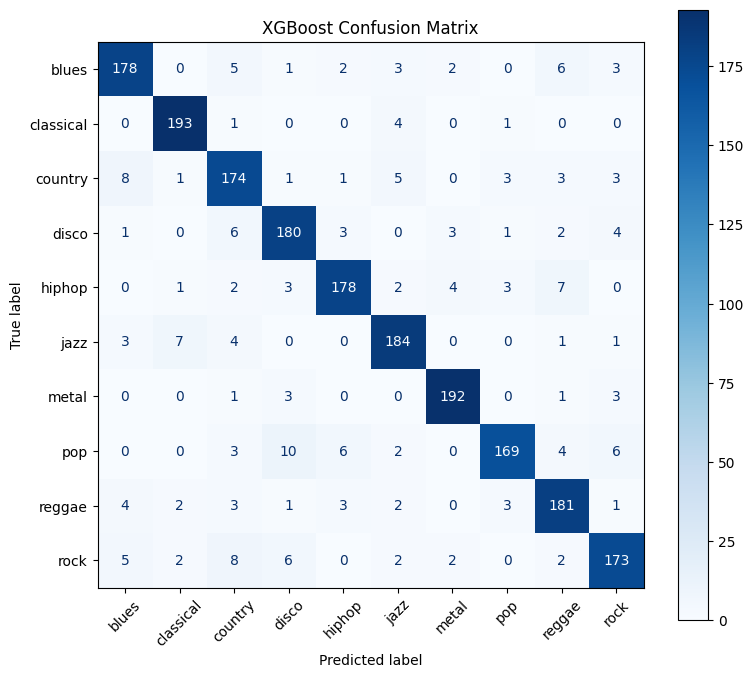

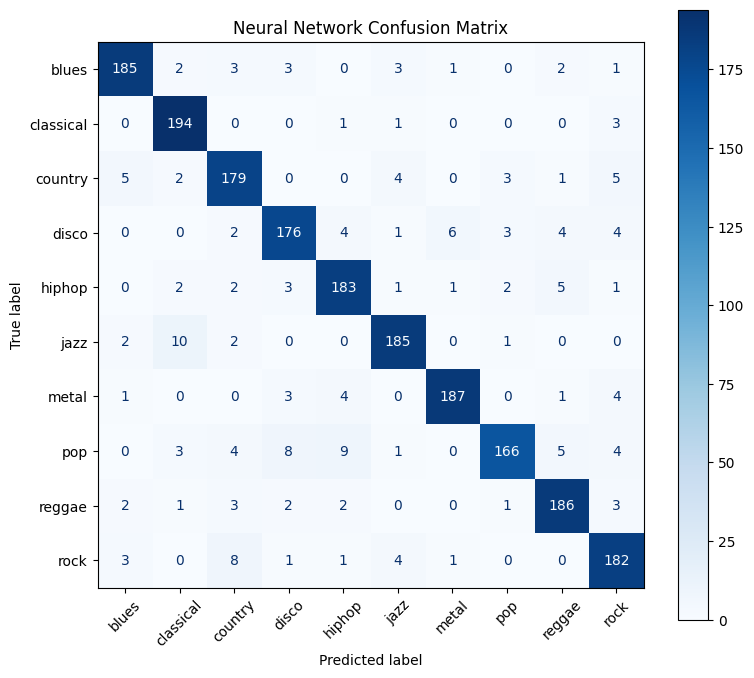

In [32]:
print("\n=== Confusion Matrices (using stored predictions) ===")
for name, preds in predicted_classes.items():
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    fig, ax = plt.subplots(figsize=(8, 7)) # Adjust size as needed
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', values_format='d')
    plt.title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

Using XGBoost for SHAP explanation.
Calculating SHAP values for 1000 test samples...
SHAP values calculated.

Generating SHAP Feature Importance Bar Plot (Top 15) for XGBoost...


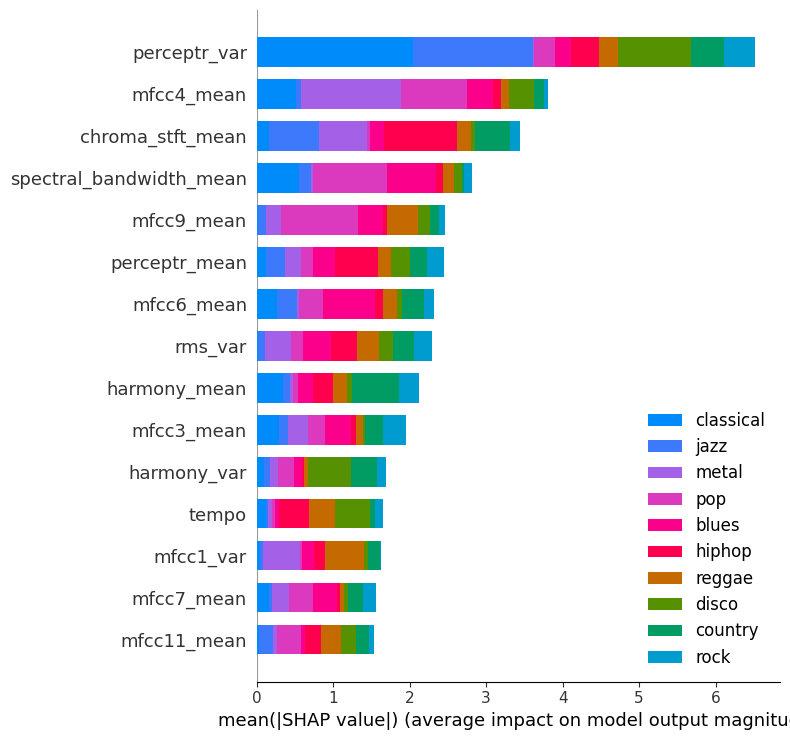


Generating SHAP Force Plot for first test sample (XGBoost)...


In [37]:
# --- Explainability with SHAP (Top 15 Feature Importance Bar Plot) ---
import shap

# Initialize SHAP (must be done after model training)
# Ensure you have run '!pip install shap' in a previous cell
try:
    shap.initjs() # Recommended for richer plots in notebooks
except Exception as e:
    print(f"Could not initialize SHAP JS: {e}. Plots will still be generated.")

# --- Choose a Model for Explanation ---
# Using XGBoost as in your example
try:
    model_to_explain = tuned_models['XGBoost'] # Ensure this key exists in your dict
    model_name = 'XGBoost'
    print(f"Using {model_name} for SHAP explanation.")

    # --- Create SHAP Explainer ---
    explainer = shap.TreeExplainer(model_to_explain)

    # --- Calculate SHAP Values ---
    # Using X_test_scaled as the model was trained on scaled data
    # Calculating for a subset for efficiency if needed, but using full test set gives better accuracy
    # num_samples_to_explain = len(X_test_scaled) # Or use a subset like 1000
    num_samples_to_explain = min(1000, len(X_test_scaled)) # Use up to 1000 samples for efficiency
    
    print(f"Calculating SHAP values for {num_samples_to_explain} test samples...")
    shap_values = explainer.shap_values(X_test_scaled[:num_samples_to_explain])
    print("SHAP values calculated.")

    # --- SHAP Feature Importance Bar Plot (Top 15) ---
    # Calculates mean(|SHAP value|) across samples for each feature and sums/averages across classes
    print(f"\nGenerating SHAP Feature Importance Bar Plot (Top 15) for {model_name}...")

    plt.figure() # Create a new figure to avoid potential overlap issues
    plt.title(f'Feature Importance ({model_name} - Top 15)') # Add title before summary_plot
    shap.summary_plot(shap_values,
                      X_test_scaled[:num_samples_to_explain],
                      feature_names=X.columns, # Make sure X is your feature DataFrame
                      plot_type='bar',         # Use 'bar' for mean absolute SHAP value plot
                      max_display=15,          # Limit to top 15 features
                      class_names=le.classes_, # Make sure le is your LabelEncoder
                      show=False)              # Prevent double plotting
    # Note: shap.summary_plot with plot_type='bar' handles multi-class averaging automatically
    plt.tight_layout()
    plt.show()


    # --- (Optional) SHAP Force Plot for a single prediction ---
    # You can keep this part if you still want individual explanations
    print(f"\nGenerating SHAP Force Plot for first test sample ({model_name})...")
    # ... (rest of the force plot code from your previous block can go here if desired) ...
    # Make sure to handle potential errors if explainer.expected_value is not available


except KeyError:
    print(f"Model '{model_name}' not found in tuned_models dictionary. Skipping SHAP analysis.")
except ImportError:
    print("SHAP library not found. Please install it using '!pip install shap'")
except Exception as e:
    print(f"An error occurred during SHAP analysis: {e}")

Using 100 samples as background data for DeepExplainer.
Created shap.DeepExplainer.
Calculating SHAP values for NN on 50 test samples...
SHAP values for NN calculated.

Generating SHAP Feature Importance Bar Plot (NN)...


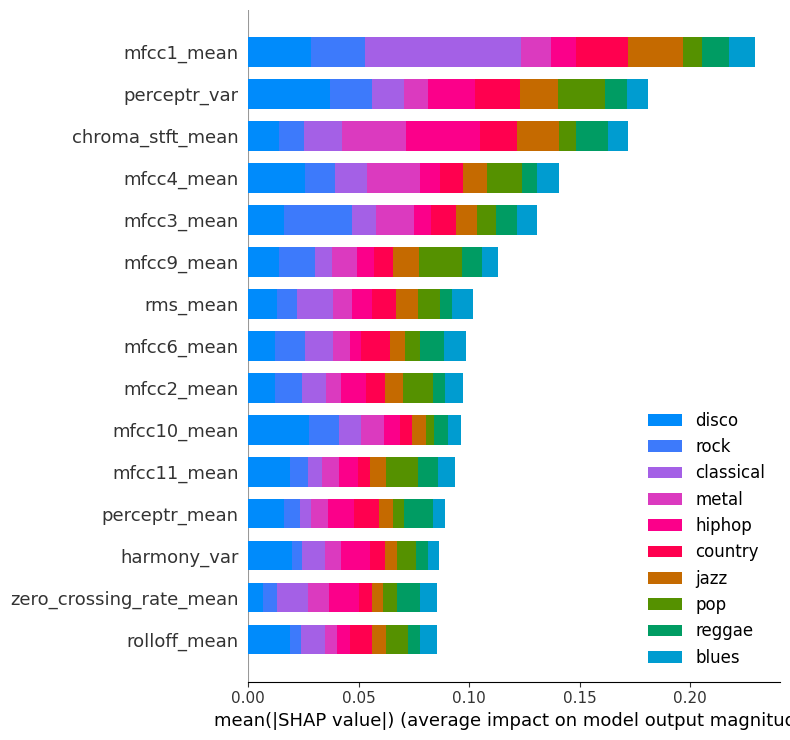

In [ ]:
# --- SHAP Explanation for Neural Network ---
# Ensure you have run '!pip install shap'

# 1. Choose a background dataset (important for DeepExplainer)
# A subset of the training data is common practice.
# Using scaled training data as the NN was trained on it.
background_data = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]
print(f"Using {len(background_data)} samples as background data for DeepExplainer.")

# 2. Create the DeepExplainer
# Pass the model and the background data
try:
    explainer_nn = shap.DeepExplainer(nn_model, background_data)
    print("Created shap.DeepExplainer.")

    # 3. Calculate SHAP values for a subset of test data
    # Using a smaller subset for faster calculation
    num_samples_explain_nn = 50
    test_subset_nn = X_test_scaled[:num_samples_explain_nn]
    print(f"Calculating SHAP values for NN on {len(test_subset_nn)} test samples...")

    # shap_values_nn will likely be a list of arrays (one per class)
    shap_values_nn = explainer_nn.shap_values(test_subset_nn)
    print("SHAP values for NN calculated.")

    # 4. Generate a summary plot (e.g., Bar plot for overall feature importance)
    # This aggregates importance across all classes
    print("\nGenerating SHAP Feature Importance Bar Plot (NN)...")
    plt.figure()
    plt.title('Feature Importance (Neural Network - Top 15)')
    shap.summary_plot(shap_values_nn,
                      test_subset_nn,
                      feature_names=X.columns, # Ensure X is your feature DataFrame
                      plot_type='bar',
                      max_display=15,
                      class_names=le.classes_, # Ensure le is your LabelEncoder
                      show=False)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nError using DeepExplainer: {e}")
    print("DeepExplainer might not be compatible with all layer types.")
    print("Consider trying KernelExplainer as an alternative (can be slow).")

#### 7. Save All Models and Artifacts

In [33]:
# ## 7. Save All Models and Artifacts

# Create directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save tuned traditional models
for name, model in tuned_models.items():
    with open(f'saved_models/{name.lower().replace(" ", "_")}_tuned.pkl', 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved tuned {name} model")

# Save neural network (complete model)
nn_model.save('saved_models/nn_complete_model.h5')
print("Saved complete neural network (architecture + weights)")

# Save preprocessing objects
with open('saved_models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

with open('saved_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nAll artifacts saved successfully!")

Saved tuned Random Forest model
Saved tuned SVM model
Saved tuned KNN model
Saved tuned Logistic Regression model
Saved tuned XGBoost model
Saved complete neural network (architecture + weights)

All artifacts saved successfully!


In [34]:
# Save feature names
with open('saved_models/feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)  # X is your training dataframe